In [1]:
import sys,os
__script_path=os.path.abspath(globals().get('__file__','.'))
__script_dir = os.path.dirname(__script_path)
root_dir = os.path.abspath(f'{__script_dir}/../..')
print(root_dir)
for lib in [root_dir][::-1]:
    if lib in sys.path:
        sys.path.remove(lib)
    sys.path.insert(0,lib)
from libs.lib import *


d:\ads_test


In [2]:
exps_dir = "../../../exps/exp1"
if os.path.exists(exps_dir) == False: # tạo thư mục (nếu chưa có)
  os.makedirs(exps_dir, exist_ok=True)

save_dir = f"{exps_dir}/data"
os.makedirs(save_dir, exist_ok=True)


In [3]:
wandb.init(
    # set the wandb project where this run will be logged
    project="ads1_prj_VGG16"
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: dinhtanloc (nckh_ueh). Use `wandb login --relogin` to force relogin


In [4]:
# Dữ liệu
x_train = pd.read_excel(f'{save_dir}/x_train.xlsx')
y_train = pd.read_excel(f'{save_dir}/y_train.xlsx')
x_test = pd.read_excel(f'{save_dir}/x_test.xlsx')
y_test = pd.read_excel(f'{save_dir}/y_test.xlsx')

In [5]:
from sklearn.metrics import f1_score
import tensorflow as tf
def f1_loss(y_true, y_pred):
    true_positives = tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, 1), tf.equal(y_pred, 1)), tf.float32))
    predicted_positives = tf.reduce_sum(tf.cast(y_pred, tf.float32))
    possible_positives = tf.reduce_sum(tf.cast(y_true, tf.float32))
    
    precision = true_positives / (predicted_positives + tf.keras.backend.epsilon())
    recall = true_positives / (possible_positives + tf.keras.backend.epsilon())
    
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return 1 - f1

In [6]:
def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
    loss = -tf.reduce_mean(alpha * tf.pow(1.0 - pt, gamma) * tf.math.log(pt))
    return loss


In [7]:
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)
    return 1 - (numerator + 1) / (denominator + 1)


In [8]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred, smooth):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_loss(y_true, y_pred, smooth=0.0001):
    return 1 - dice_coef(y_true, y_pred, smooth)

In [9]:
from keras import backend as K

def f1_score(y_true, y_pred):
    """
    F1 score metric.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_score = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_score

In [10]:
from tensorflow.keras.optimizers.legacy import Adam
from keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D, Dense, Flatten
from keras.models import Model
from keras.layers import Input
import tensorflow as tf
input_shape =(x_train.shape[1],1)
x_input = Input(shape=input_shape)
dense_units = 1024
learning_rate = 0.0001
kernel_size =3
filter_size=96


# Block 1
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv1')(x_input)
x = Conv1D(filter_size, kernel_size, activation='relu', padding='same', name='block1_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block1_pool')(x)

# Block 2
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv1')(x)
x = Conv1D(filter_size*2, kernel_size, activation='relu', padding='same', name='block2_conv2')(x)
x = MaxPooling1D(2, strides=2, name='block2_pool')(x)

# Block 3
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv1')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv2')(x)
x = Conv1D(filter_size*4, kernel_size, activation='relu', padding='same', name='block3_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block3_pool')(x)

# Block 4
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block4_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block4_pool')(x)

# Block 5
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv1')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv2')(x)
x = Conv1D(filter_size*8, kernel_size, activation='relu', padding='same', name='block5_conv3')(x)
x = MaxPooling1D(2, strides=2, name='block5_pool')(x)

# x = Flatten(name='flatten')(x)
# x = Dense(dense_units, activation='relu', name='fc1')(x)
# x = Dense(dense_units, activation='relu', name='fc2')(x)
# x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

x = GlobalAveragePooling1D()(x)
# x = GlobalMaxPooling1D()(x)
# x = Dense(2, activation='softmax', name='predictions')(x)  # Sigmoid for binary classification
x = Dense(1, activation='sigmoid', name='predictions')(x)  # Sigmoid for binary classification

# Create model.
model = Model(x_input, x, name='vgg16')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='binary_crossentropy', metrics=['accuracy',f1_score])

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=f1_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=focal_loss, metrics=['accuracy',f1_score])
# model.compile(optimizer=Adam(lr=learning_rate), loss=dice_coef_loss, metrics=['accuracy',f1_score])
early_stopping = EarlyStopping(monitor='val_accuracy',
    # min_delta=0.00005,
    patience=10,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.95,
    patience=5,
    min_lr=0.000001,
    verbose=1,
)


In [11]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 34, 1)]           0         
                                                                 
 block1_conv1 (Conv1D)       (None, 34, 96)            384       
                                                                 
 block1_conv2 (Conv1D)       (None, 34, 96)            27744     
                                                                 
 block1_pool (MaxPooling1D)  (None, 17, 96)            0         
                                                                 
 block2_conv1 (Conv1D)       (None, 17, 192)           55488     
                                                                 
 block2_conv2 (Conv1D)       (None, 17, 192)           110784    
                                                                 
 block2_pool (MaxPooling1D)  (None, 8, 192)            0     

In [12]:
def show_pic(times):
    history=model.history.history
    fig,axes=plt.subplots(1,2, figsize=(15,8))
    axes[0].plot(pd.DataFrame(history['val_accuracy']))
    axes[0].set_title('Training Process')

    axes[1].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
    axes[1].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
    axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
    axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
    axes[1].set_title(f'Training Process in {times}')
    axes[1].legend()
    plt.show()


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/30
146/146 [==============================] - ETA: 0s - loss: 0.2553 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.3s


146/146 [==============================] - 58s 380ms/step - loss: 0.2553 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2482 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/30
146/146 [==============================] - ETA: 0s - loss: 0.2299 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.3s


146/146 [==============================] - 66s 450ms/step - loss: 0.2299 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2410 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/30
146/146 [==============================] - 56s 381ms/step - loss: 0.2190 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2856 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/30
146/146 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.4s


146/146 [==============================] - 56s 384ms/step - loss: 0.2119 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2113 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 5/30
146/146 [==============================] - 52s 357ms/step - loss: 0.2031 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2127 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 6/30
146/146 [==============================] - ETA: 0s - loss: 0.1967 - accuracy: 0.9412 - f1_score: 0.0000e+00
Epoch 6: ReduceLROnPlateau reducing learning rate to 9.499999760009814e-05.
146/146 [==============================] - 52s 358ms/step - loss: 0.1967 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2127 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 1.0000e-04
Epoch 7/30
146/146 [==============================] - ETA: 0s - loss: 0.1954 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model

INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.4s


146/146 [==============================] - 55s 380ms/step - loss: 0.1954 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2097 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 9.5000e-05
Epoch 8/30
146/146 [==============================] - ETA: 0s - loss: 0.1903 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.4s


146/146 [==============================] - 54s 372ms/step - loss: 0.1903 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2042 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 9.5000e-05
Epoch 9/30
146/146 [==============================] - 53s 361ms/step - loss: 0.1914 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2087 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 9.5000e-05
Epoch 10/30
146/146 [==============================] - ETA: 0s - loss: 0.1853 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.3s


146/146 [==============================] - 57s 391ms/step - loss: 0.1853 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2038 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 9.5000e-05
Epoch 11/30
146/146 [==============================] - ETA: 0s - loss: 0.1847 - accuracy: 0.9412 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.2s


Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 9.02499959920533e-05.
146/146 [==============================] - 57s 391ms/step - loss: 0.1847 - accuracy: 0.9412 - f1_score: 0.0000e+00 - val_loss: 0.2024 - val_accuracy: 0.9333 - val_f1_score: 0.0000e+00 - lr: 9.5000e-05
Epoch 11: early stopping


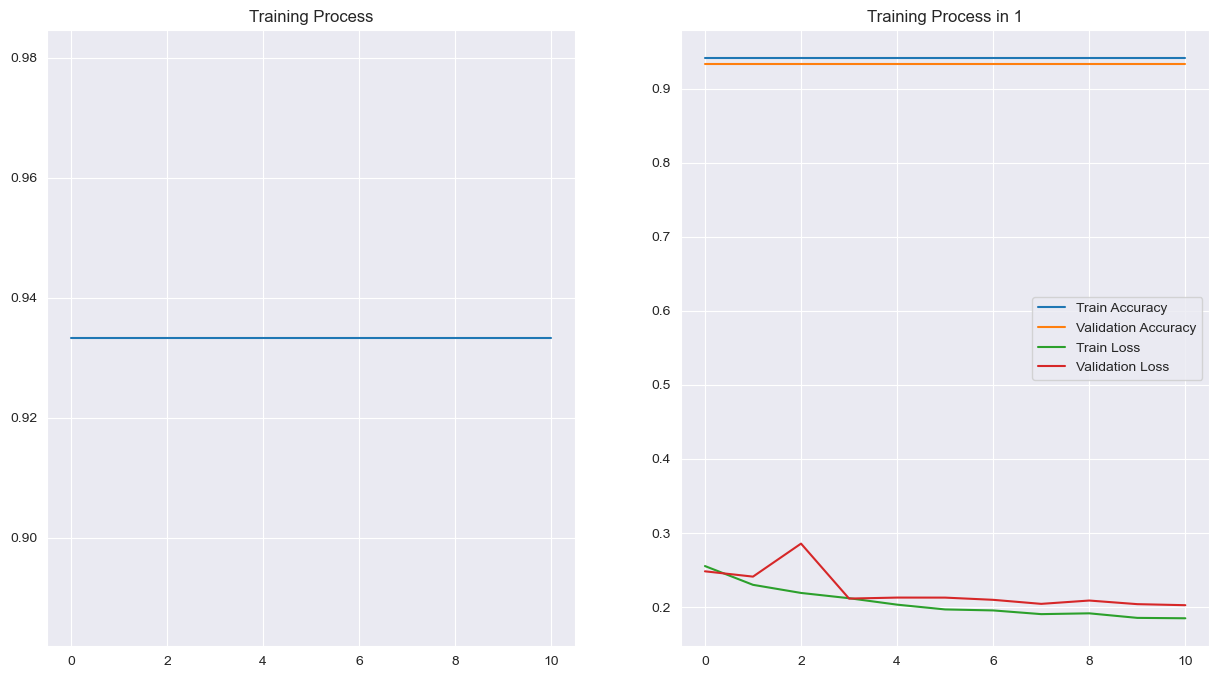

Epoch 1/30
146/146 [==============================] - 53s 364ms/step - loss: 0.2375 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.2158 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 9.0250e-05
Epoch 2/30
146/146 [==============================] - 57s 392ms/step - loss: 0.2294 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.2317 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 9.0250e-05
Epoch 3/30
146/146 [==============================] - 56s 384ms/step - loss: 0.2328 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.2107 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 9.0250e-05
Epoch 4/30
146/146 [==============================] - ETA: 0s - loss: 0.2187 - accuracy: 0.9398 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.3s


146/146 [==============================] - 56s 384ms/step - loss: 0.2187 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1956 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 9.0250e-05
Epoch 5/30
146/146 [==============================] - 49s 338ms/step - loss: 0.2085 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1964 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 9.0250e-05
Epoch 6/30
146/146 [==============================] - ETA: 0s - loss: 0.2027 - accuracy: 0.9398 - f1_score: 0.0000e+00
Epoch 6: ReduceLROnPlateau reducing learning rate to 8.573749619245064e-05.
146/146 [==============================] - 50s 344ms/step - loss: 0.2027 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.2035 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 9.0250e-05
Epoch 7/30
146/146 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9398 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model

INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.3s


146/146 [==============================] - 55s 376ms/step - loss: 0.2032 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1797 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 8.5737e-05
Epoch 8/30
146/146 [==============================] - ETA: 0s - loss: 0.1969 - accuracy: 0.9398 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.3s


146/146 [==============================] - 53s 365ms/step - loss: 0.1969 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1794 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 8.5737e-05
Epoch 9/30
146/146 [==============================] - 53s 365ms/step - loss: 0.1927 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1809 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 8.5737e-05
Epoch 10/30
146/146 [==============================] - 57s 388ms/step - loss: 0.1894 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.2335 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 8.5737e-05
Epoch 11/30
146/146 [==============================] - ETA: 0s - loss: 0.1922 - accuracy: 0.9398 - f1_score: 0.0000e+00Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 8.145062311086804e-05.
146/146 [==============================] - 51s 351ms/step - loss: 0.1922 - accuracy: 0.9398 - f1_score: 0.0000e+00 - v

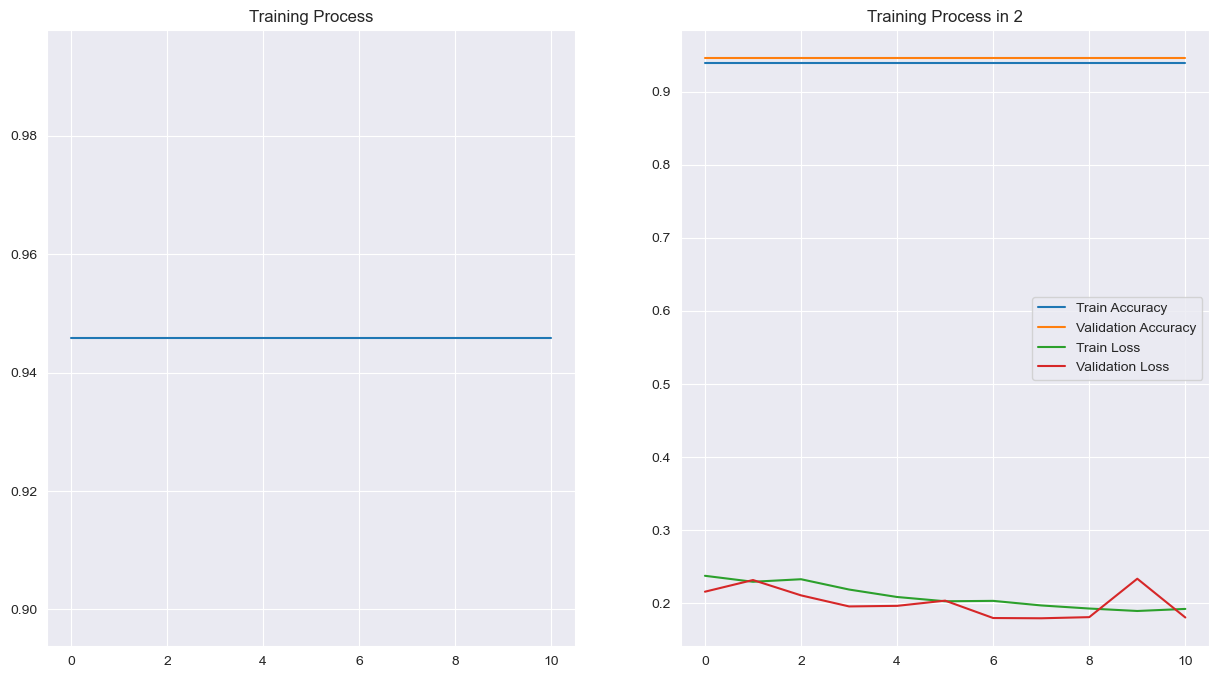

Epoch 1/30
146/146 [==============================] - 52s 354ms/step - loss: 0.2287 - accuracy: 0.9405 - f1_score: 0.0000e+00 - val_loss: 0.2555 - val_accuracy: 0.9390 - val_f1_score: 0.0000e+00 - lr: 8.1451e-05
Epoch 2/30
146/146 [==============================] - 49s 338ms/step - loss: 0.2228 - accuracy: 0.9405 - f1_score: 0.0000e+00 - val_loss: 0.2257 - val_accuracy: 0.9390 - val_f1_score: 0.0000e+00 - lr: 8.1451e-05
Epoch 3/30
146/146 [==============================] - 50s 344ms/step - loss: 0.2182 - accuracy: 0.9405 - f1_score: 0.0000e+00 - val_loss: 0.2272 - val_accuracy: 0.9390 - val_f1_score: 0.0000e+00 - lr: 8.1451e-05
Epoch 4/30
146/146 [==============================] - 52s 353ms/step - loss: 0.2094 - accuracy: 0.9405 - f1_score: 0.0000e+00 - val_loss: 0.2147 - val_accuracy: 0.9390 - val_f1_score: 0.0000e+00 - lr: 8.1451e-05
Epoch 5/30
146/146 [==============================] - 51s 348ms/step - loss: 0.2065 - accuracy: 0.9405 - f1_score: 0.0000e+00 - val_loss: 0.2158 - val_a

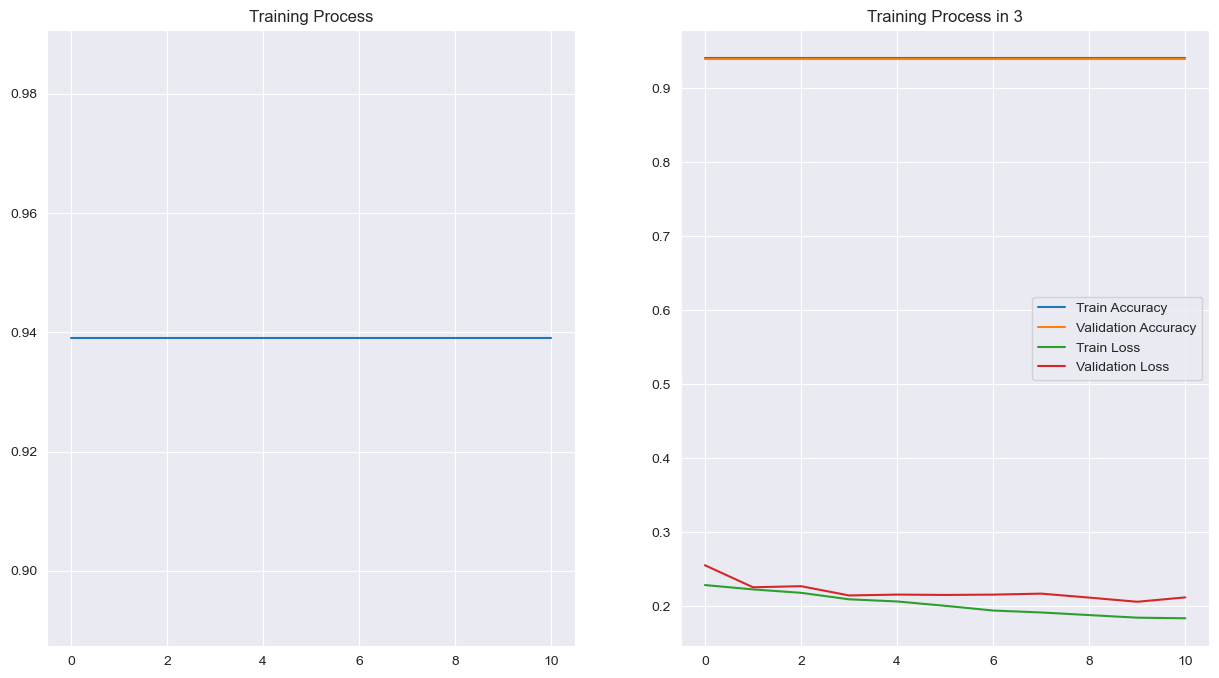

Epoch 1/30
146/146 [==============================] - 55s 378ms/step - loss: 0.2293 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1954 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 7.3509e-05
Epoch 2/30
146/146 [==============================] - 56s 381ms/step - loss: 0.2199 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1878 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 7.3509e-05
Epoch 3/30
146/146 [==============================] - 54s 369ms/step - loss: 0.2129 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1996 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 7.3509e-05
Epoch 4/30
146/146 [==============================] - 53s 366ms/step - loss: 0.2123 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1796 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 7.3509e-05
Epoch 5/30
146/146 [==============================] - ETA: 0s - loss: 0.2080 - accuracy: 0.9390 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to:

INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.4s


146/146 [==============================] - 56s 386ms/step - loss: 0.2080 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1718 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 7.3509e-05
Epoch 6/30
146/146 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9390 - f1_score: 0.0000e+00
Epoch 6: ReduceLROnPlateau reducing learning rate to 6.983372950344346e-05.
146/146 [==============================] - 52s 357ms/step - loss: 0.2024 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1808 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 7.3509e-05
Epoch 7/30
146/146 [==============================] - ETA: 0s - loss: 0.1970 - accuracy: 0.9390 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.4s


146/146 [==============================] - 55s 376ms/step - loss: 0.1970 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1711 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 6.9834e-05
Epoch 8/30
146/146 [==============================] - 53s 364ms/step - loss: 0.1929 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1722 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 6.9834e-05
Epoch 9/30
146/146 [==============================] - 52s 358ms/step - loss: 0.1925 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1718 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 6.9834e-05
Epoch 10/30
146/146 [==============================] - ETA: 0s - loss: 0.1908 - accuracy: 0.9390 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.3s


146/146 [==============================] - 55s 378ms/step - loss: 0.1908 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1705 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 6.9834e-05
Epoch 11/30
146/146 [==============================] - ETA: 0s - loss: 0.1907 - accuracy: 0.9390 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.2s


Restoring model weights from the end of the best epoch: 1.

Epoch 11: ReduceLROnPlateau reducing learning rate to 6.634204510191921e-05.
146/146 [==============================] - 56s 387ms/step - loss: 0.1907 - accuracy: 0.9390 - f1_score: 0.0000e+00 - val_loss: 0.1694 - val_accuracy: 0.9526 - val_f1_score: 0.0000e+00 - lr: 6.9834e-05
Epoch 11: early stopping


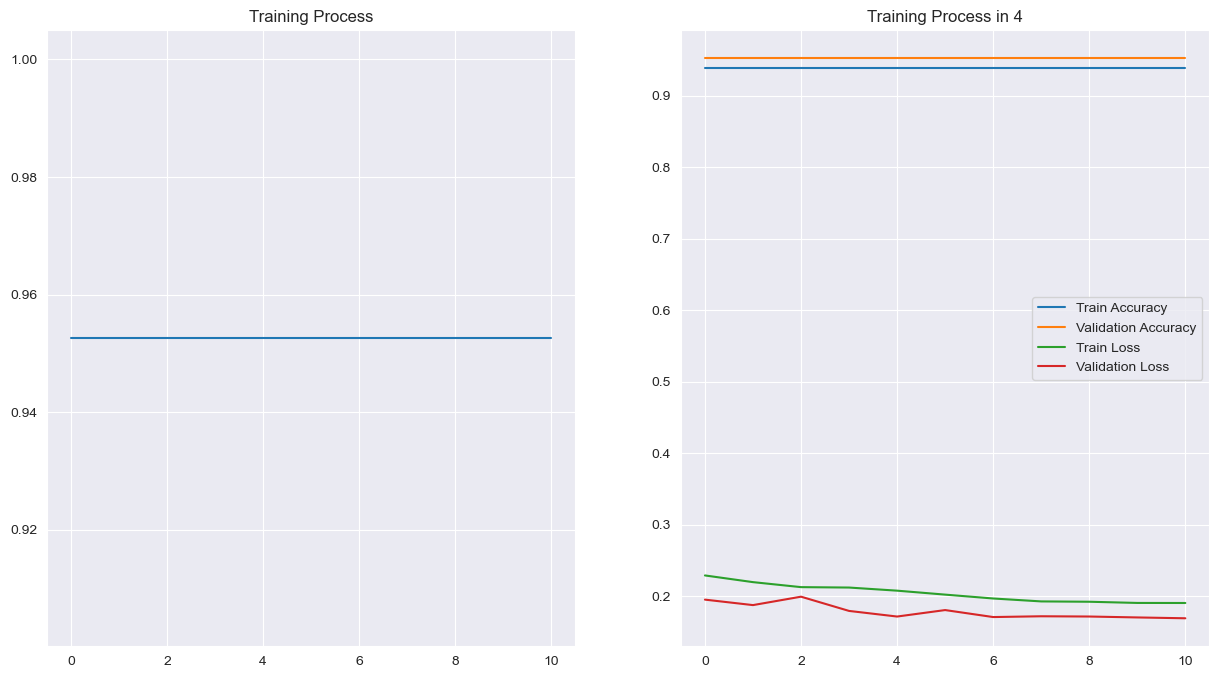

Epoch 1/30
146/146 [==============================] - 51s 351ms/step - loss: 0.2189 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1981 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 6.6342e-05
Epoch 2/30
146/146 [==============================] - 54s 373ms/step - loss: 0.2134 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.2001 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 6.6342e-05
Epoch 3/30
146/146 [==============================] - 56s 383ms/step - loss: 0.2093 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1925 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 6.6342e-05
Epoch 4/30
146/146 [==============================] - 55s 378ms/step - loss: 0.2026 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1971 - val_accuracy: 0.9458 - val_f1_score: 0.0000e+00 - lr: 6.6342e-05
Epoch 5/30
146/146 [==============================] - 52s 354ms/step - loss: 0.2000 - accuracy: 0.9398 - f1_score: 0.0000e+00 - val_loss: 0.1890 - val_a

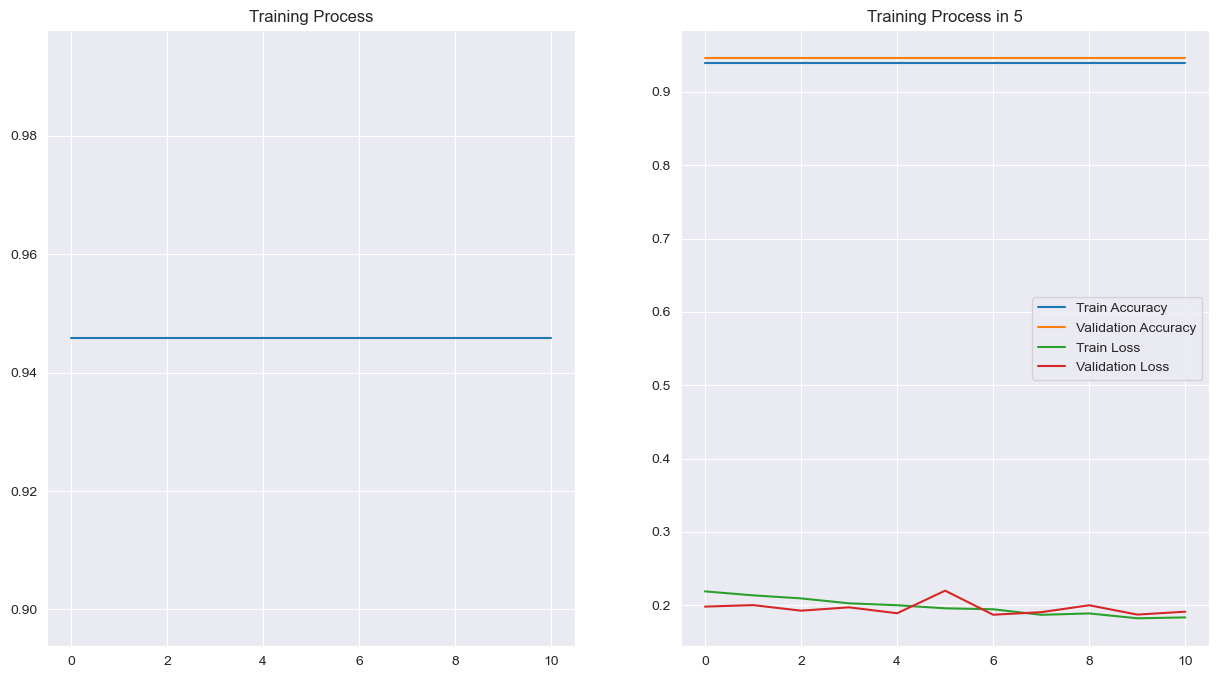

Epoch 1/30
146/146 [==============================] - 51s 347ms/step - loss: 0.2111 - accuracy: 0.9413 - f1_score: 0.0000e+00 - val_loss: 0.2190 - val_accuracy: 0.9322 - val_f1_score: 0.0000e+00 - lr: 5.9874e-05
Epoch 2/30
146/146 [==============================] - 51s 352ms/step - loss: 0.2051 - accuracy: 0.9413 - f1_score: 0.0000e+00 - val_loss: 0.2181 - val_accuracy: 0.9322 - val_f1_score: 0.0000e+00 - lr: 5.9874e-05
Epoch 3/30
146/146 [==============================] - 51s 348ms/step - loss: 0.2003 - accuracy: 0.9413 - f1_score: 0.0000e+00 - val_loss: 0.2163 - val_accuracy: 0.9322 - val_f1_score: 0.0000e+00 - lr: 5.9874e-05
Epoch 4/30
146/146 [==============================] - 51s 351ms/step - loss: 0.1950 - accuracy: 0.9413 - f1_score: 0.0000e+00 - val_loss: 0.2159 - val_accuracy: 0.9322 - val_f1_score: 0.0000e+00 - lr: 5.9874e-05
Epoch 5/30
146/146 [==============================] - 51s 348ms/step - loss: 0.1951 - accuracy: 0.9413 - f1_score: 0.0000e+00 - val_loss: 0.2167 - val_a

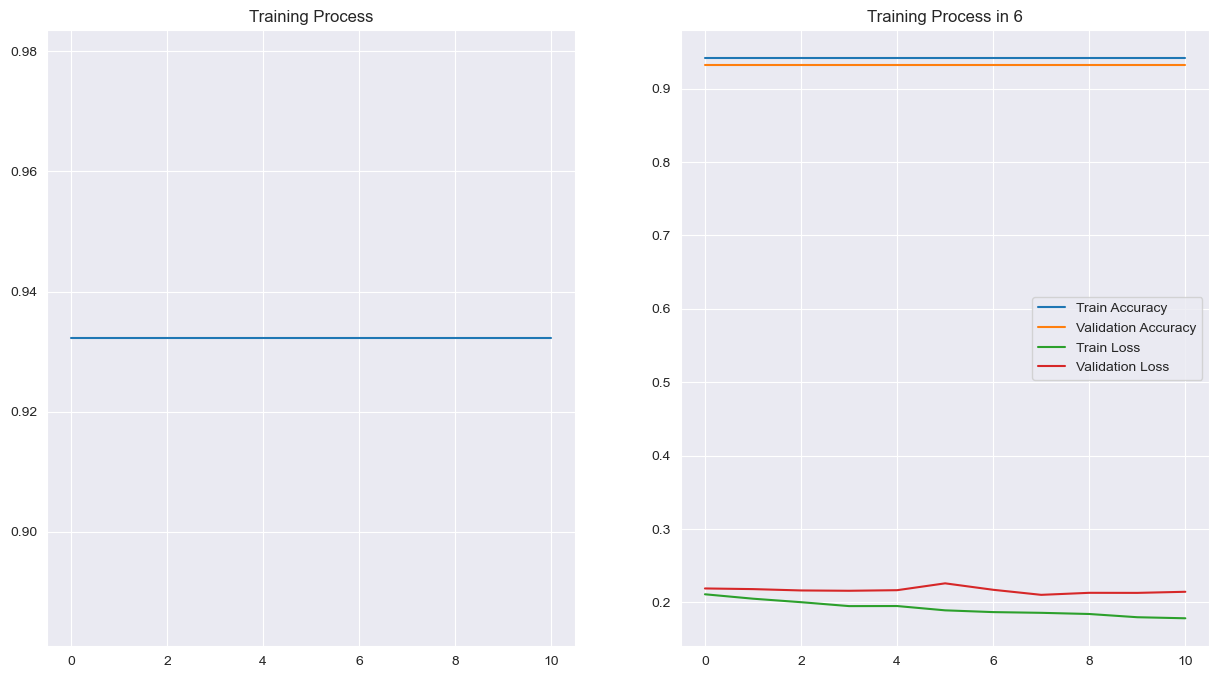

Epoch 1/30
146/146 [==============================] - 51s 346ms/step - loss: 0.2038 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2330 - val_accuracy: 0.9313 - val_f1_score: 0.0000e+00 - lr: 5.4036e-05
Epoch 2/30
146/146 [==============================] - 52s 355ms/step - loss: 0.2028 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2231 - val_accuracy: 0.9313 - val_f1_score: 0.0000e+00 - lr: 5.4036e-05
Epoch 3/30
146/146 [==============================] - 52s 354ms/step - loss: 0.2005 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2265 - val_accuracy: 0.9313 - val_f1_score: 0.0000e+00 - lr: 5.4036e-05
Epoch 4/30
146/146 [==============================] - 53s 365ms/step - loss: 0.1957 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2219 - val_accuracy: 0.9313 - val_f1_score: 0.0000e+00 - lr: 5.4036e-05
Epoch 5/30
146/146 [==============================] - 52s 354ms/step - loss: 0.1944 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2157 - val_a

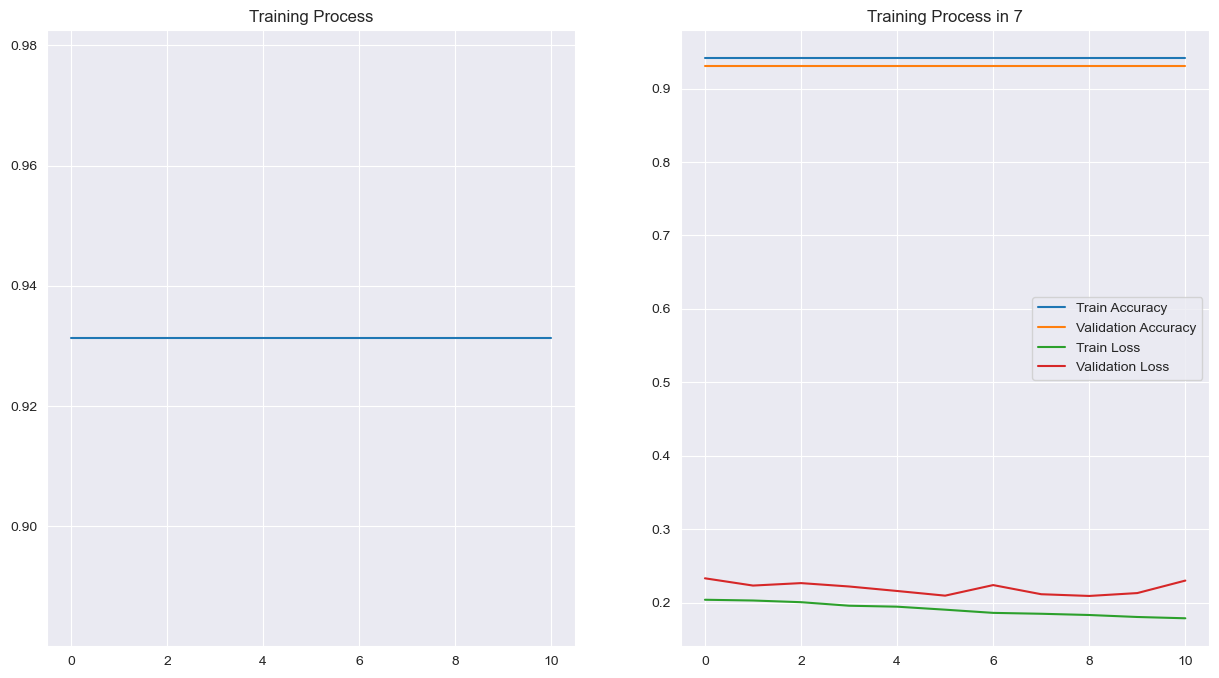

Epoch 1/30
146/146 [==============================] - ETA: 0s - loss: 0.2087 - accuracy: 0.9394 - f1_score: 0.0000e+00INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets


INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.3s


146/146 [==============================] - 57s 394ms/step - loss: 0.2087 - accuracy: 0.9394 - f1_score: 0.0000e+00 - val_loss: 0.1688 - val_accuracy: 0.9487 - val_f1_score: 0.0000e+00 - lr: 4.8767e-05
Epoch 2/30
146/146 [==============================] - 53s 364ms/step - loss: 0.2034 - accuracy: 0.9394 - f1_score: 0.0000e+00 - val_loss: 0.1729 - val_accuracy: 0.9487 - val_f1_score: 0.0000e+00 - lr: 4.8767e-05
Epoch 3/30
146/146 [==============================] - 50s 342ms/step - loss: 0.1989 - accuracy: 0.9394 - f1_score: 0.0000e+00 - val_loss: 0.1790 - val_accuracy: 0.9487 - val_f1_score: 0.0000e+00 - lr: 4.8767e-05
Epoch 4/30
146/146 [==============================] - 51s 351ms/step - loss: 0.1967 - accuracy: 0.9394 - f1_score: 0.0000e+00 - val_loss: 0.1706 - val_accuracy: 0.9487 - val_f1_score: 0.0000e+00 - lr: 4.8767e-05
Epoch 5/30
146/146 [==============================] - 57s 394ms/step - loss: 0.1923 - accuracy: 0.9394 - f1_score: 0.0000e+00 - val_loss: 0.1721 - val_accuracy: 0.

INFO:tensorflow:Assets written to: d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best\assets
wandb: Adding directory to artifact (d:\ads_test\prj1\5.deep_learning_model\VGG16\wandb\run-20240403_203211-8ig8h8mg\files\model-best)... Done. 0.3s



Epoch 6: ReduceLROnPlateau reducing learning rate to 4.63291238702368e-05.
146/146 [==============================] - 55s 374ms/step - loss: 0.1937 - accuracy: 0.9394 - f1_score: 0.0000e+00 - val_loss: 0.1679 - val_accuracy: 0.9487 - val_f1_score: 0.0000e+00 - lr: 4.8767e-05
Epoch 7/30
146/146 [==============================] - 52s 357ms/step - loss: 0.1886 - accuracy: 0.9394 - f1_score: 0.0000e+00 - val_loss: 0.1757 - val_accuracy: 0.9487 - val_f1_score: 0.0000e+00 - lr: 4.6329e-05
Epoch 8/30
146/146 [==============================] - 50s 343ms/step - loss: 0.1854 - accuracy: 0.9394 - f1_score: 0.0000e+00 - val_loss: 0.1772 - val_accuracy: 0.9487 - val_f1_score: 0.0000e+00 - lr: 4.6329e-05
Epoch 9/30
146/146 [==============================] - 49s 335ms/step - loss: 0.1870 - accuracy: 0.9394 - f1_score: 0.0000e+00 - val_loss: 0.1739 - val_accuracy: 0.9487 - val_f1_score: 0.0000e+00 - lr: 4.6329e-05
Epoch 10/30
146/146 [==============================] - 50s 343ms/step - loss: 0.1800 - 

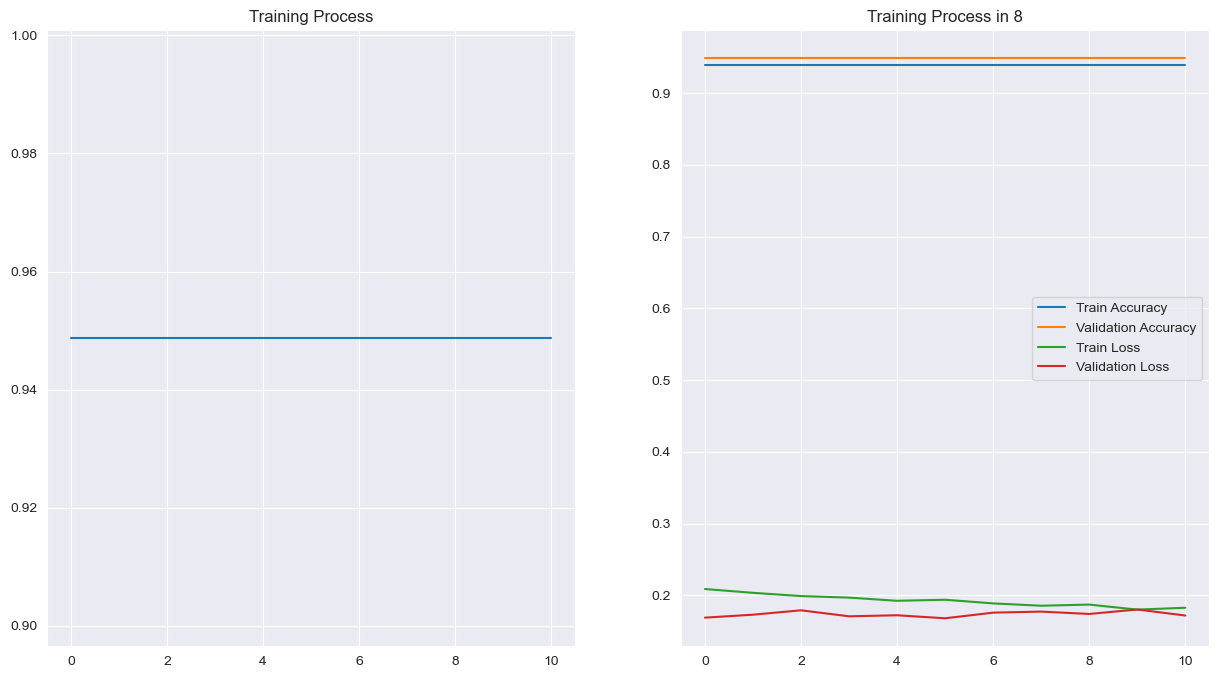

Epoch 1/30
146/146 [==============================] - 54s 368ms/step - loss: 0.2003 - accuracy: 0.9400 - f1_score: 0.0000e+00 - val_loss: 0.1896 - val_accuracy: 0.9439 - val_f1_score: 0.0000e+00 - lr: 4.4013e-05
Epoch 2/30
146/146 [==============================] - 54s 367ms/step - loss: 0.1976 - accuracy: 0.9400 - f1_score: 0.0000e+00 - val_loss: 0.2008 - val_accuracy: 0.9439 - val_f1_score: 0.0000e+00 - lr: 4.4013e-05
Epoch 3/30
146/146 [==============================] - 52s 353ms/step - loss: 0.1966 - accuracy: 0.9400 - f1_score: 0.0000e+00 - val_loss: 0.2048 - val_accuracy: 0.9439 - val_f1_score: 0.0000e+00 - lr: 4.4013e-05
Epoch 4/30
146/146 [==============================] - 55s 376ms/step - loss: 0.1941 - accuracy: 0.9400 - f1_score: 0.0000e+00 - val_loss: 0.1884 - val_accuracy: 0.9439 - val_f1_score: 0.0000e+00 - lr: 4.4013e-05
Epoch 5/30
146/146 [==============================] - 54s 372ms/step - loss: 0.1900 - accuracy: 0.9400 - f1_score: 0.0000e+00 - val_loss: 0.1834 - val_a

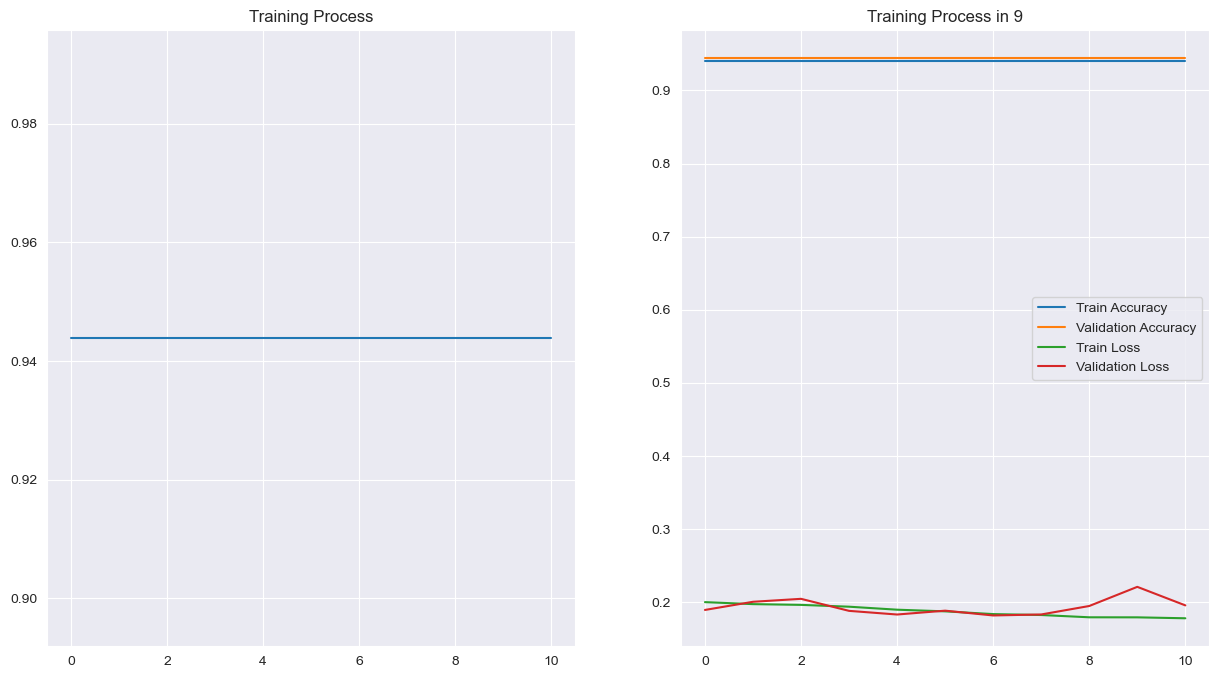

Epoch 1/30
146/146 [==============================] - 53s 362ms/step - loss: 0.1929 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2167 - val_accuracy: 0.9313 - val_f1_score: 0.0000e+00 - lr: 3.9721e-05
Epoch 2/30
146/146 [==============================] - 54s 369ms/step - loss: 0.1901 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2202 - val_accuracy: 0.9313 - val_f1_score: 0.0000e+00 - lr: 3.9721e-05
Epoch 3/30
146/146 [==============================] - 54s 368ms/step - loss: 0.1874 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2389 - val_accuracy: 0.9313 - val_f1_score: 0.0000e+00 - lr: 3.9721e-05
Epoch 4/30
146/146 [==============================] - 52s 359ms/step - loss: 0.1858 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2227 - val_accuracy: 0.9313 - val_f1_score: 0.0000e+00 - lr: 3.9721e-05
Epoch 5/30
146/146 [==============================] - 54s 368ms/step - loss: 0.1841 - accuracy: 0.9414 - f1_score: 0.0000e+00 - val_loss: 0.2323 - val_a

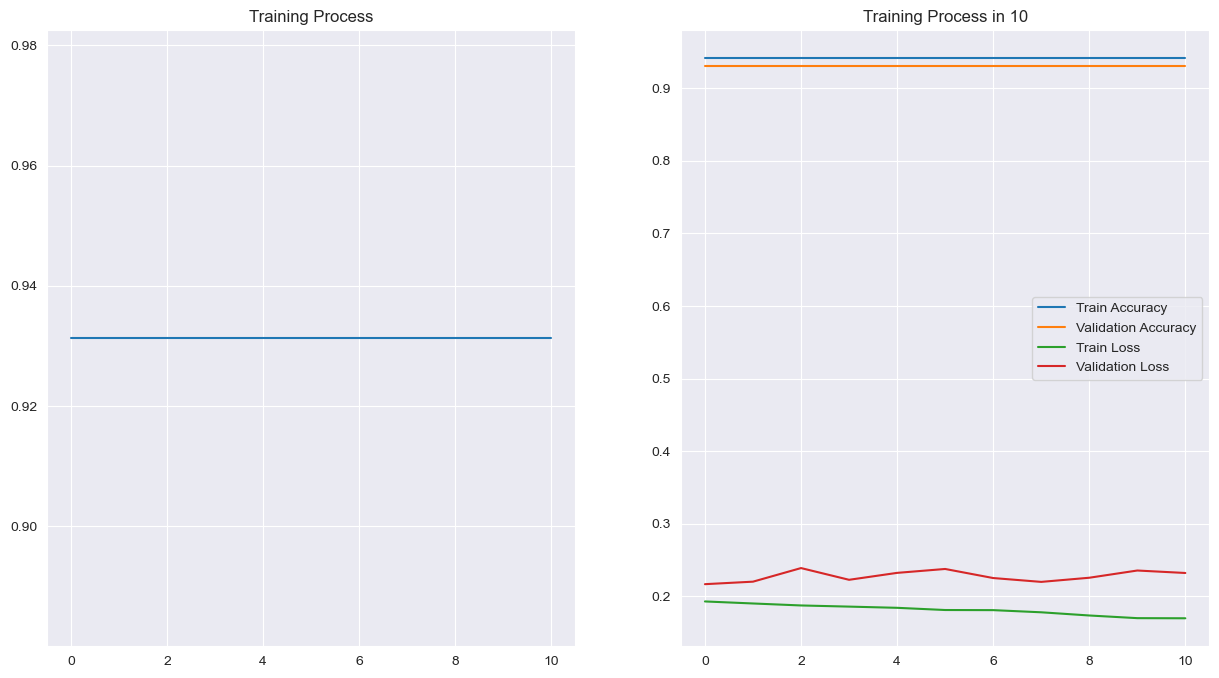

In [13]:
# Số lượng folds
n_splits = 10

# KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)


times=0

# Tạo và đào tạo mô hình với K-Fold
# Tạo và đào tạo mô hình với K-Fold
for train_index, val_index in kf.split(x_train):
    times+=1
    X_train_fold, X_val_fold = x_train.iloc[train_index], x_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
    # Chuyển đổi tf.Tensor thành mảng NumPy nếu cần thiết
    X_train_fold = X_train_fold.numpy() if isinstance(X_train_fold, tf.Tensor) else X_train_fold
    y_train_fold = y_train_fold.numpy() if isinstance(y_train_fold, tf.Tensor) else y_train_fold
    X_val_fold = X_val_fold.numpy() if isinstance(X_val_fold, tf.Tensor) else X_val_fold
    y_val_fold = y_val_fold.numpy() if isinstance(y_val_fold, tf.Tensor) else y_val_fold
    model.fit(X_train_fold, y_train_fold, epochs=30, batch_size=64, validation_data=(X_val_fold, y_val_fold),callbacks=[wandb.keras.WandbCallback(),early_stopping,lr_scheduler])
    show_pic(times)


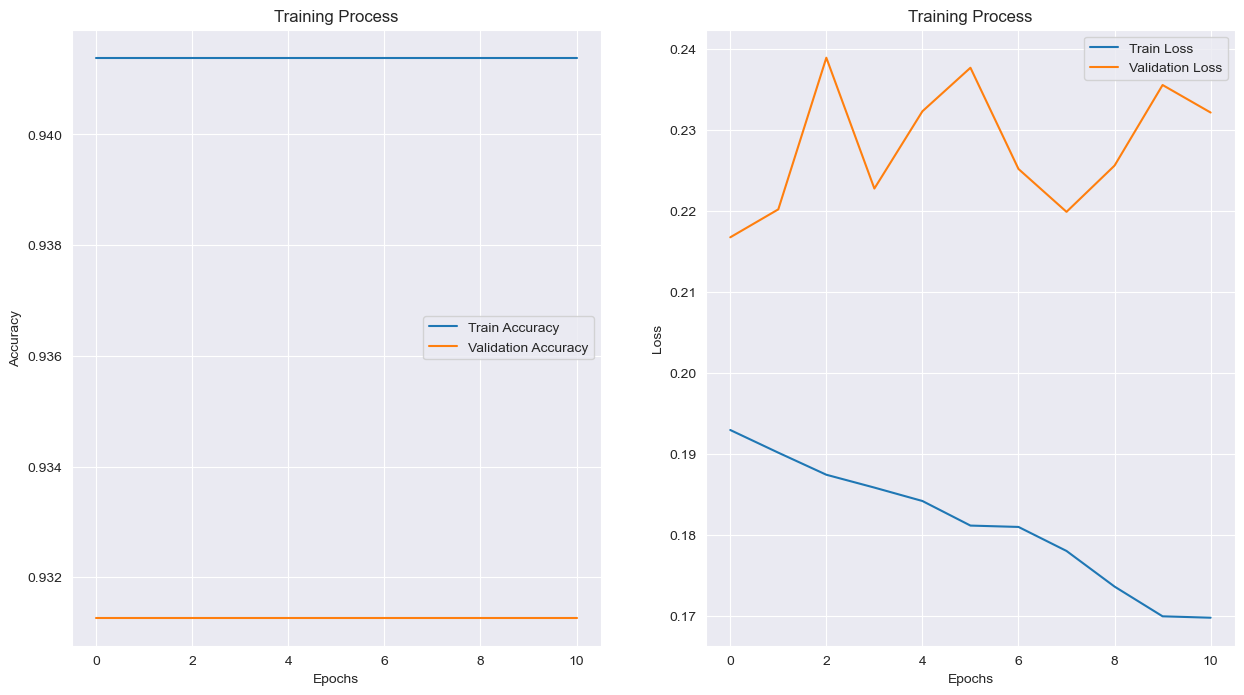

<Figure size 640x480 with 0 Axes>

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
history = model.history.history

# Vẽ biểu đồ
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Biểu đồ accuracy của tập kiểm tra và tập validation
axes[0].plot(pd.DataFrame(history['accuracy']), label='Train Accuracy')
axes[0].plot(pd.DataFrame(history['val_accuracy']), label='Validation Accuracy')
axes[0].set_title('Training Process')
axes[0].set_xlabel('Epochs')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# Biểu đồ loss của tập kiểm tra và tập validation
axes[1].plot(pd.DataFrame(history['loss']), label='Train Loss')
axes[1].plot(pd.DataFrame(history['val_loss']), label='Validation Loss')
axes[1].set_title('Training Process')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Hiển thị biểu đồ
plt.show()

# Lưu biểu đồ vào file
plt.savefig('train.png')


In [15]:
predictions = model.predict(x_test)
predictions = np.argmax(predictions, axis=1)
accuracy = accuracy_score(y_test, predictions)
accuracy

160/160 [==============================] - 2s 12ms/step


0.9396738062487718

In [16]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# Hiển thị báo cáo phân loại
print("Classification Report:")
print(classification_report(y_test, predictions,labels=[1,0]))

# # Hiển thị ma trận nhầm lẫn
# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_pred,labels=[1,0]))

Accuracy: 0.9396738062487718
Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       307
           0       0.94      1.00      0.97      4782

    accuracy                           0.94      5089
   macro avg       0.47      0.50      0.48      5089
weighted avg       0.88      0.94      0.91      5089



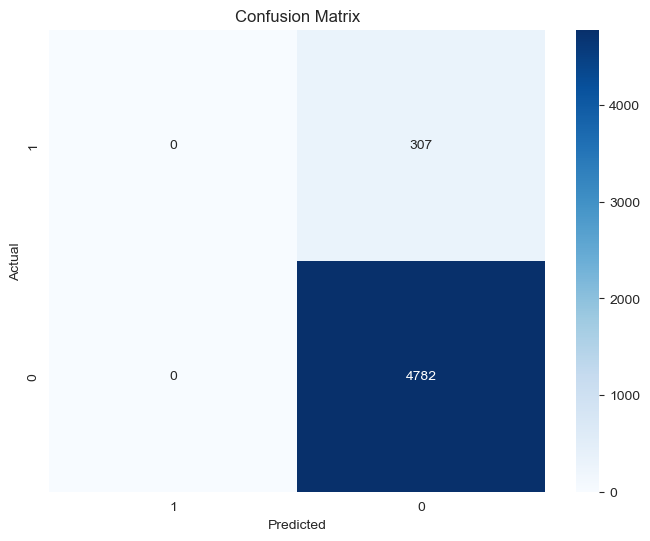

In [17]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, predictions,labels=[1,0])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[1,0], yticklabels=[1,0])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

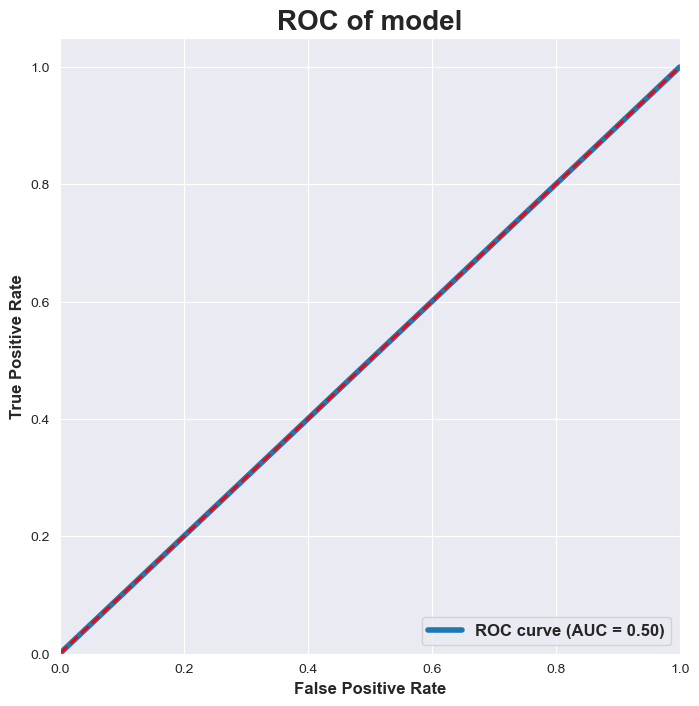

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_test, predictions,ax,name='model'):    
    # Tính toán FPR và TPR từ decision function
    fpr, tpr, _ = roc_curve(y_test, predictions)
    
    # Tính diện tích dưới đường cong ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # Vẽ đường cong ROC
    ax.plot(fpr, tpr, lw=4, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', fontsize=12, weight='bold')  # Đặt kích thước và độ dày cho nhãn trục x
    ax.set_ylabel('True Positive Rate', fontsize=12, weight='bold')   # Đặt kích thước và độ dày cho nhãn trục y
    ax.set_title(f'ROC of {name}',fontsize=20, weight='bold')  # Đặt kích thước và độ dày cho tiêu đề
    ax.legend(loc="lower right", prop={'size': 12, 'weight': 'bold'})  # Đặt kích thước và độ dày cho chú thích

fig, axes = plt.subplots(1, 1, figsize=(8, 8))

plot_roc_curve(y_test,predictions,axes)
# predictions

In [19]:
def check_result(prediction):
    prediction = (prediction > 0.5).astype(int)
    if isinstance(prediction, (np.ndarray, pd.Series)):
        prediction = prediction.item()  # Hoặc sử dụng prediction[0] hoặc prediction.iloc[0]
    if prediction==1:
        return "Y"
    else:
        return "N"

In [20]:
solandung=0
hopdonggianlan=0
for indx in range(len(x_test)):
    y_predict = predictions
    #print(y_predict[0][0])
    Y_check = check_result(y_test.iloc[indx])
    print('True:', Y_check)
    print('Predicted:', check_result(y_predict[indx]))
    print("----------------------------")
    if Y_check==check_result(y_predict[indx]):
        solandung+=1
        if Y_check=='Y':
            hopdonggianlan+=1
    

True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: Y
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------
True: N
Predicted: N
----------------------------


In [21]:
print(f"Số lần dự đoán đúng: {solandung} chiếm khoảng {(solandung/len(x_test))*100}% tổng lần dự đoán")
print(f"Số hợp đồng gian lận trong lần kiểm tra: {hopdonggianlan} chiếm khoảng {(hopdonggianlan/len(y_test[y_test['FraudFound_P']==1]))*100}% so với thực tế")

Số lần dự đoán đúng: 4782 chiếm khoảng 93.96738062487718% tổng lần dự đoán
Số hợp đồng gian lận trong lần kiểm tra: 0 chiếm khoảng 0.0% so với thực tế
